Tutorial of SpatialGRN
---

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

System parameters setting

In [2]:
from SpatialGRN.config import config
opt = config()
args = opt.parse_args(['--gpu', '0'])
args.dataset_path = '../Data/Mouse_Brain'
args

Namespace(clusters=0, dataset_path='../Data/Mouse_Brain', embed_dim=10, flow='source_to_target', gpu=0, hops=3, hvgs=3000, infer_mode='simplex', latent_dim=50, log_file='../Log', log_steps=10, lr=0.001, max_epoch=1000, max_neighbors=8, n_hops=3, n_randomwalk=[5, 10, 15], out_file='../Output', project_name='SpatialGRN', q_randomwalk=[1, 1.5], seed=2024, spread=0.003, srt_resolution=2, tau=1, version='v_1.0', visualize=True, wegiht_decay=1e-06)

Set random seed

In [3]:
from SpatialGRN.utils import set_random_seed
set_random_seed(args.seed)

Reading dataset

In [4]:
adata = sc.read_h5ad(os.path.join(args.dataset_path, 'adata_RNA.h5ad'))
adata

AnnData object with n_obs × n_vars = 9215 × 22914
    obs: 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_peaks', 'nFeature_peaks', 'RNA_clusters', 'ATAC_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap', 'spatial'

SpatialGRN initialization

In [5]:
from SpatialGRN.spatialgrn import SpatailGRN
sg = SpatailGRN(args, adata)

using device cuda:0
Average spatial edge: 7.8708133971291865


Tokenization of genes

In [6]:
from SpatialGRN.tokenizer import GeneRep
embedding = GeneRep(sg.args)(sg.x, sg.edge_index)
embedding.size()

torch.Size([9196, 3000, 10])

In [7]:
import torch
torch.save(embedding, os.path.join(sg.args.out_file, os.path.basename(sg.args.dataset_path)+'.pt'))

Training Transformer-based model

In [8]:
sg.fit(embedding)

  0%|          | 0/1000 [00:00<?, ?it/s]

EP[   0]: loss=1.1420.


Getting the spot-specific gene interaction matrix

In [ ]:
sgrn = sg.eval(embedding[:3])

Visiualiztion of GRN

In [ ]:
attn_weights = sgrn
attn_weights.size()

tensor([[[-0.2409, -0.4777, -0.1278,  ..., -0.1126, -0.0630,  0.0313],
         [ 0.4728, -0.9919,  0.1464,  ...,  0.0805, -0.0718,  0.3824],
         [-0.1349, -0.2397, -0.0375,  ..., -0.0062,  0.0973,  0.1760],
         ...,
         [ 0.0274, -0.6568, -0.0688,  ..., -0.1691, -0.0702,  0.0742],
         [-0.1684, -0.1842, -0.0636,  ...,  0.0831,  0.0838,  0.1383],
         [-0.2105,  0.4329, -0.0471,  ...,  0.0772,  0.1826,  0.1376]],

        [[ 0.0345,  0.0661,  0.0655,  ..., -0.0019,  0.1586,  0.1768],
         [-0.0154, -0.0367, -0.0370,  ..., -0.1322,  0.0520,  0.1079],
         [-0.0159, -0.0370, -0.0373,  ..., -0.1325,  0.0537,  0.1072],
         ...,
         [ 0.0293, -0.0592, -0.0572,  ..., -0.1151,  0.0929,  0.1045],
         [-0.0780, -0.0587, -0.0587,  ..., -0.1728,  0.0654,  0.0784],
         [-0.1357, -0.1214, -0.1239,  ..., -0.2221, -0.0997, -0.0117]],

        [[-0.0102, -0.0427, -0.0422,  ...,  0.0542, -0.0576, -0.1598],
         [-0.0322, -0.0375, -0.0379,  ...,  0

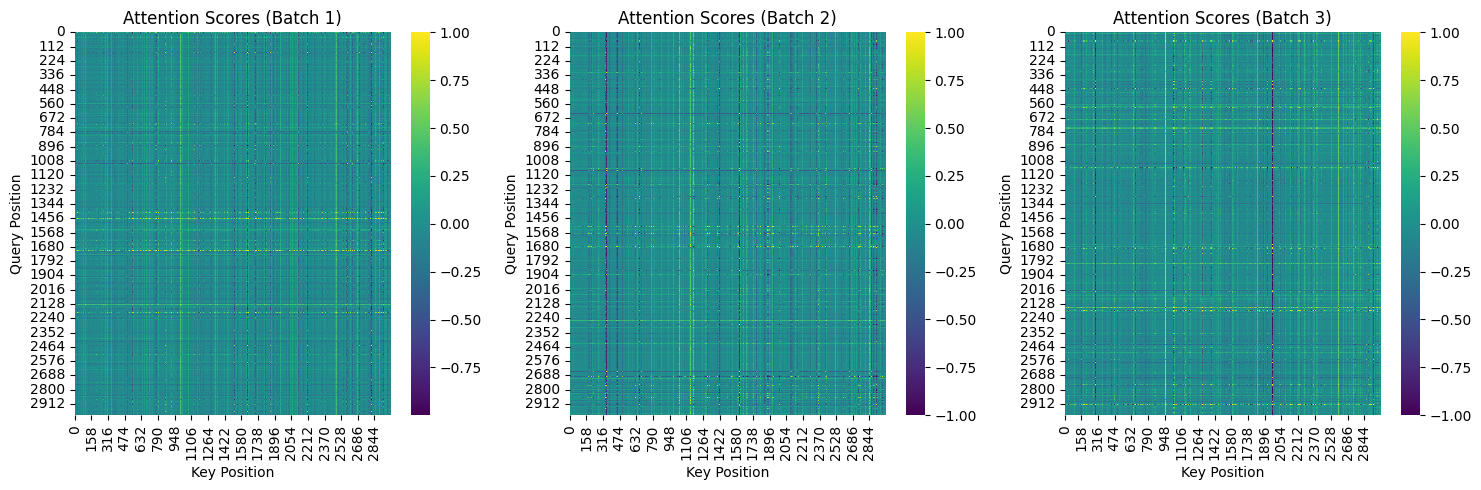

In [ ]:
# 注意力得分可视化
import seaborn as sns
def visualize_attention(attn_weights, title="Attention Scores"):
    # 假设 attn_weights 形状为 (batch_size, seq_len, seq_len)
    attn_weights = attn_weights
    fig, axes = plt.subplots(1, attn_weights.shape[0], figsize=(15, 5))
    
    for i in range(attn_weights.shape[0]):
        sns.heatmap(attn_weights[i], ax=axes[i], annot=False, cmap='viridis')
        axes[i].set_title(f"{title} (Batch {i+1})")
        axes[i].set_xlabel("Key Position")
        axes[i].set_ylabel("Query Position")
    
    plt.tight_layout()
    plt.show()

# 可视化注意力得分
visualize_attention(attn_weights, title="Attention Scores")


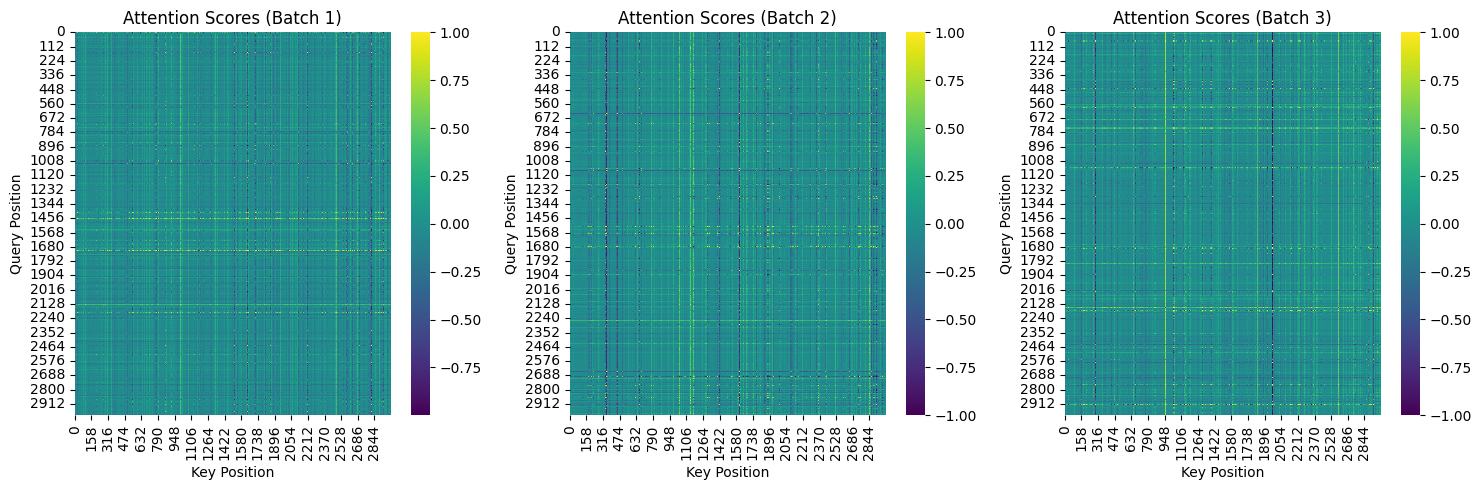